In [1]:
import os
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

In [2]:
pd.set_option("max_colwidth", 100)

In [3]:
from google.cloud import storage

In [4]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [5]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [6]:
# Reading data from open bucket, avaible to all students
bucket_read = 'msca-bdp-data-open'

# Saving results into individual bucket, students must update to their own bucket
bucket_write = 'msca-bdp-data-shared'

In [7]:
!hdfs dfs -ls gs://msca-bdp-amazon/amazon_reviews/

Found 46 items
-rwx------   3 root root 1971061630 2020-10-28 20:26 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Apparel_v1_00.tsv
-rwx------   3 root root 1350294084 2020-10-28 20:26 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Automotive_v1_00.tsv
-rwx------   3 root root  872274720 2020-10-28 20:26 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Baby_v1_00.tsv
-rwx------   3 root root 2152186111 2020-10-28 20:27 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Beauty_v1_00.tsv
-rwx------   3 root root 6699171766 2020-10-28 20:29 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Books_v1_00.tsv
-rwx------   3 root root 6703921864 2020-10-28 20:31 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Books_v1_01.tsv
-rwx------   3 root root 3238702530 2020-10-28 20:32 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Books_v1_02.tsv
-rwx------   3 root root 1100169988 2020-10-28 20:32 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Camera_v1_

In [8]:
path = "gs://msca-bdp-amazon/amazon_reviews"
amazon = spark.read.csv(path, header='true', inferSchema='true', sep='\t', quote='')

In [9]:
amazon.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [10]:
amazonpd = amazon.limit(5).toPandas()
amazonpd

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,22873041,R3ARRMDEGED8RD,B00KJWQIIC,335625766,"Plemo 14-Inch Laptop Sleeve Case Waterproof Fabric Bag for MacBook Air / Laptops / Notebook, Gray",PC,5,0,0,N,Y,Pleasantly surprised,"I was very surprised at the high quality of the stitching, the sturdiness of the handles and the...",2015-08-31
1,US,30088427,RQ28TSA020Y6J,B013ALA9LA,671157305,TP-Link OnHub AC1900 Wireless Wi-Fi Router,PC,5,24,31,N,N,OnHub is a pretty no nonsense type router that just works,I am a Google employee and had to chance to use the device for a few months now. This is my own ...,2015-08-31
2,US,20329786,RUXJRZCT6953M,B00PML2GQ8,982036237,AmazonBasics USB 3.0 A Male to A Male Cable - 3.3 Feet 1 Meter,PC,1,2,2,N,N,None of them worked. No functionality at all.,"Bought cables in 3ft, 6ft and 9ft. NONE of them worked. NO FUNCTIONALITY WHATSOEVER. Tested m...",2015-08-31
3,US,14215710,R7EO0UO6BPB71,B001NS0OZ4,576587596,Transcend P8 15-in-1 USB 2.0 Flash Memory Card Reader TS-RDP8K,PC,1,0,0,N,Y,just keep searching.,"nope, cheap and slow",2015-08-31
4,US,38264512,R39NJY2YJ1JFSV,B00AQMTND2,964759214,Aleratec SATA Data Cable 2.0 20in Serial ATA Straight Connector 6-Pack Combo,PC,5,0,0,N,Y,Five Stars,Excellent! Great value and does the job.,2015-08-31


## Question 1: Which product category gets most reviews

In [11]:
reviewcount = amazon.groupby('product_category').agg(
                            count("product_id").alias("count"))
reviewcount1 = reviewcount.orderBy('count',ascending = False)
reviewcount1.limit(5).show()

+--------------------+--------+
|    product_category|   count|
+--------------------+--------+
|               Books|19531329|
|Digital_Ebook_Pur...|17622415|
|            Wireless| 9002021|
|                  PC| 6908554|
|                Home| 6221559|
+--------------------+--------+



#### The books category bets most reviews

## Question 2: Which product category gets highest / lowest review star ratings


In [12]:
reviewrating = amazon.groupby('product_category').agg(
                            avg("star_rating").alias("avg_rating"))
reviewrating1 = reviewrating.orderBy('avg_rating',ascending = False)
reviewrating1.limit(5).show()

+--------------------+-----------------+
|    product_category|       avg_rating|
+--------------------+-----------------+
|           Gift Card|4.731363105858364|
|Digital_Music_Pur...|4.642891400475107|
|               Music|4.436623672519671|
|               Books|4.341658317260438|
|             Grocery|4.312218569481756|
+--------------------+-----------------+



In [13]:
reviewrating2 = reviewrating.orderBy('avg_rating',ascending = True)
reviewrating2.limit(20).show()

+--------------------+------------------+
|    product_category|        avg_rating|
+--------------------+------------------+
|    Digital_Software|3.5393303553935973|
|            Software|3.5670354545215264|
|    Major Appliances|  3.71618455949887|
|  Mobile_Electronics| 3.763162657775661|
| Digital_Video_Games|3.8531262248076406|
|            Wireless|3.8917787461282307|
|  Home Entertainment|3.9021234216711127|
|Personal_Care_App...| 3.977401984159291|
|         Mobile_Apps|3.9815944606562277|
|         Electronics| 4.035506997872243|
|         Video Games| 4.059892597803915|
|     Office Products|  4.07253918167871|
|           Furniture| 4.083948881030863|
|                  PC| 4.086443704427873|
|     Lawn and Garden|  4.09317683420874|
|             Apparel| 4.105229251381526|
|              Camera| 4.127015151162003|
|             Watches| 4.138282726523408|
|        Pet Products| 4.143652697306231|
|             Jewelry| 4.144090266004357|
+--------------------+------------

#### As we can see from the table, the Gift Card gets highest rating, while the digital software gets the lowest rating

## Question 3: Do you see seasonality in reviews?
### Is every product category getting consistent number of reviews throughout the year?
### Any product categories that are getting more reviews during certain times of the year?  If yes, which product categories and what times of the year?

In [14]:
reviewcount3 = amazon.groupby('product_category','review_date').\
                            agg(count("*").alias('count')).\
                            withColumn('review_date', to_date('review_date'))
reviewcount4 = reviewcount3.orderBy('review_date',ascending = True)
reviewcount4.limit(5).show()

+----------------+-----------+-----+
|product_category|review_date|count|
+----------------+-----------+-----+
|           Books| 1995-06-24|    2|
|           Books| 1995-07-07|    1|
|           Books| 1995-07-18|    1|
|           Books| 1995-07-19|    2|
|           Books| 1995-07-22|    4|
+----------------+-----------+-----+



In [15]:
reviewcount5 = reviewcount4.groupby('review_date').agg(sum('count').alias('count')).\
                                                      withColumn('review_date', to_date('review_date'))
reviewcount5.limit(5).show()

+-----------+-----+
|review_date|count|
+-----------+-----+
| 2008-10-31| 6074|
| 2012-11-08|34519|
| 2003-09-06| 2375|
| 2011-09-15|18776|
| 2010-09-02| 7942|
+-----------+-----+



<AxesSubplot:xlabel='review_date'>

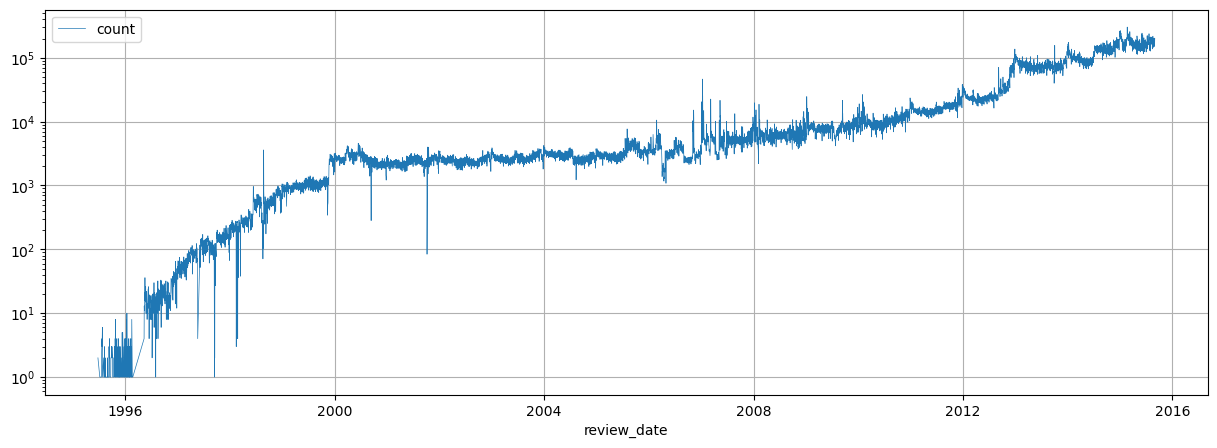

In [57]:
reviewcountplot1 = reviewcount5.filter(col('review_date').isNotNull()).toPandas()
reviewcountplot1.plot(
    figsize = [15,5],
    kind = 'line', grid = True, logy = True, linewidth = 0.5,
    x = 'review_date', y = 'count'
)

In [17]:
yearmonth = amazon.withColumn('year',substring('review_date',1,4)).filter(col("year").isNotNull()).\
                    withColumn('month',substring('review_date',6,2)).filter(col("month").isNotNull())

In [18]:
reviewcount31 = yearmonth.groupby('product_category','month').agg(count('*').alias('count')).\
                                    orderBy("product_category",'month',ascending = True)
reviewcount32 = reviewcount31.toPandas()


[None, None]

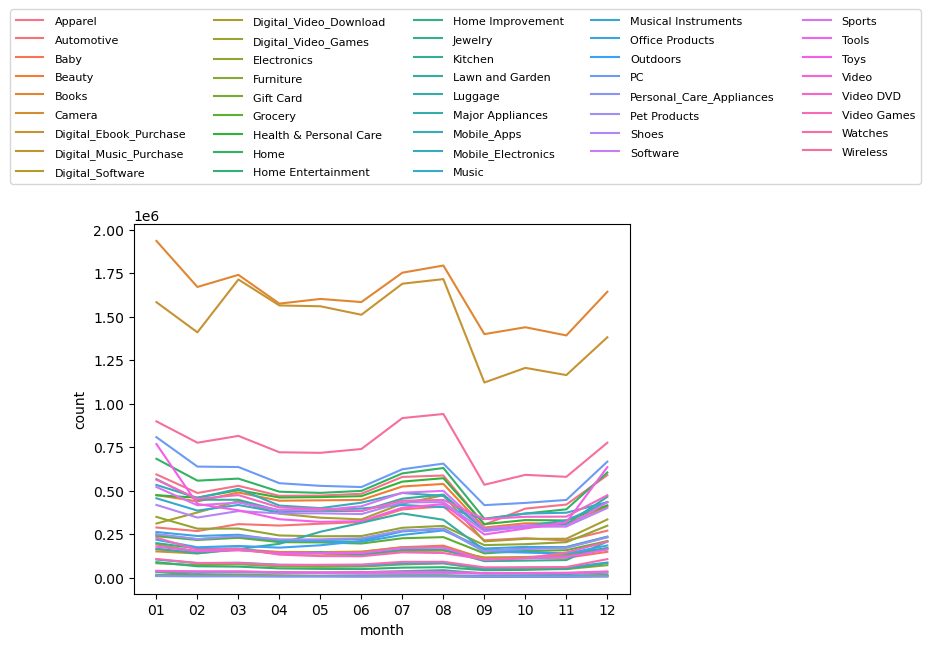

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

reviewcountplot2 = sns.lineplot(x=reviewcount32["month"], y=reviewcount32["count"], hue=reviewcount32["product_category"], data=reviewcount32)
reviewcountplot2.legend(bbox_to_anchor=(1.6, 1.6),loc="upper right", ncol = 5)
plt.setp(reviewcountplot2.get_legend().get_texts(), fontsize='8') 
plt.setp(reviewcountplot2.get_legend().get_title(), fontsize='8')

#### It is clear from the plots above that there is no consistent number of reviews throughout the years

In [20]:
yearmonth = amazon.withColumn('year',substring('review_date',1,4)).\
                    withColumn('month',substring('review_date',6,2))

In [21]:
yeartime = yearmonth.select('year','month','product_category')
yeartime.limit(5).show()

+----+-----+----------------+
|year|month|product_category|
+----+-----+----------------+
|2015|   08|              PC|
|2015|   08|              PC|
|2015|   08|              PC|
|2015|   08|              PC|
|2015|   08|              PC|
+----+-----+----------------+



In [22]:
MonthCount = yeartime.groupby('product_category','year','month').\
agg(count('product_category').alias("CountbyMonth"))
MonthCount = MonthCount.withColumn("yearmonth",col("year")*100 + col("month"))
pandasMonthCount = MonthCount.toPandas()

In [23]:
maxcountbymonth=pandasMonthCount.loc[pandasMonthCount.groupby(["product_category","year"])['CountbyMonth'].idxmax()]
showtable=maxcountbymonth.groupby(['product_category','month']).size().sort_values().groupby(level=0).tail(1).reset_index()
showtable.head(10)
showtable.groupby('month').agg(count('*')).orderBy('month',ascending = True)


,product_category,month,0
0,Mobile_Apps,12,3
1,Digital_Video_Games,12,4
2,Digital_Software,03,4
3,Music,12,6
4,Personal_Care_Appliances,01,6
5,Outdoors,12,6
6,Digital_Ebook_Purchase,12,6
7,Digital_Video_Download,12,6
8,Luggage,12,6
9,Shoes,12,7


In [ ]:
len(showtable.loc[showtable.month =='12'])

### Q3 Answer: 

#### It is clear from the plots above that there is no consistent number of reviews throughout the years

#### There are a lot of categories that are geeting more reviews during December, there are 37 catogories having their highest number of reviews in December

## Question 4: Which reviews are getting the most helpful votes / total votes?
### Any correlation between the length of review headline / review body (in number words) and the "helpfulness" of the review?
### Do you see any correlation between how many reviews a certain customer (customer_id) published and the "helpfulness" of the reviews?

In [25]:
@udf(returnType=IntegerType())
def word_count(x):
    if x:
        return(len(x.split(" ")))

In [58]:
helpful_total = amazon.withColumn('helpfulness',(amazon['helpful_votes'])/(amazon['total_votes'])).\
                                withColumn('headlinelength',word_count(amazon.review_headline).cast(IntegerType())).\
                                 withColumn('bodylength',word_count(amazon.review_body).cast(IntegerType()))

helpful_total= helpful_total.orderBy('helpfulness',ascending = False)

helpful_totalshow=helpful_total.limit(5).toPandas()
helpful_totalshow



,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,helpfulness,headlinelength,bodylength
0,US,38147176,R3L0QLMOLW2GN6,B0091L3NS0,83834149,"8GB Kit (4GBx2) Upgrade for a Apple MacBook Pro (13-inch, Late 2011) System (DDR3 PC3-10600, NON...",PC,4,1,1,N,Y,Memory for Macbook Pro late 2011,It took a week to get it delivered but it kit was new and worked great.,2015-08-31,1.0,6,16
1,US,35237777,R36QB084FK8JP5,B003MVZ60S,26704042,WD 1TB My Book AV DVR Expander External Hard Drive - USB 2.0 - WDBABT0010HBK-NESN,PC,5,1,1,N,Y,Five Stars,Excellent quick service and a good product !,2015-08-31,1.0,2,8
2,US,37018693,R2QEQK2UHCZSFZ,B01065S79E,268745989,Seagate Game Drive for Xbox SSD (STFT512400),PC,4,2,2,Y,N,"Lacking instructions, but a great looking, functional add-on for any Xbox","I still recall the day I upgraded my 20GB Xbox 360 HD with a 100GB HD and thinking, &#34;There, ...",2015-08-31,1.0,11,389
3,US,20329786,RUXJRZCT6953M,B00PML2GQ8,982036237,AmazonBasics USB 3.0 A Male to A Male Cable - 3.3 Feet 1 Meter,PC,1,2,2,N,N,None of them worked. No functionality at all.,"Bought cables in 3ft, 6ft and 9ft. NONE of them worked. NO FUNCTIONALITY WHATSOEVER. Tested m...",2015-08-31,1.0,9,52
4,US,45003190,R1II85ETIHO6VK,B001MNTVNQ,178273423,Original Microsoft Xbox 360 Power Supply AC Adapter 203W,PC,1,1,1,N,Y,One Star,Not the Xbox 360 power supply,2015-08-31,1.0,2,6


In [41]:

helpful= helpful_total.groupby('review_id').agg(sum('helpful_votes').alias('sum_helpful'))
helpful1 = helpful.orderBy('sum_helpful',ascending = False)
helpful1.limit(31).show()                      

+--------------+-----------+
|     review_id|sum_helpful|
+--------------+-----------+
|R3R24QH3CDS83N|      47524|
|R19XO9PS38WRWO|      41393|
|R2XKMDXZHQ26YX|      41278|
|R2YVZNKUMWGYJ4|      31924|
|R1PL1U31XQG8KG|      31417|
| RBUNL9QWDYTD7|      28611|
|R2JF7E91JJVHAT|      27550|
|R3PG4OX6C5KVN4|      26132|
| RV0R3AODMRNJZ|      24714|
| RXXPVOUH9NLL3|      23755|
|R1JMDSX89JG82B|      20928|
|R1LT38SAC0FA4G|      18429|
|R2PKU2MR4GXKG7|      18217|
|R1F9TEE07IWGR7|      16982|
| ROZW9HYI4CYCC|      16563|
|R3IZ72Z3AJ1DCF|      16401|
|R19VDCH6ME7S72|      16053|
|R2VDKZ4X1F992Q|      15835|
|R1087TPNE2K7NA|      15457|
|R2VX6G023G4D9Y|      13828|
+--------------+-----------+
only showing top 20 rows



In [42]:
helpful= helpful_total.groupby('review_id').agg(sum('total_votes').alias('sum_total'))
helpful1 = helpful.orderBy('sum_total',ascending = False)
helpful1.limit(3).show()  

+--------------+---------+
|     review_id|sum_total|
+--------------+---------+
|R3R24QH3CDS83N|    48362|
|R2XKMDXZHQ26YX|    41889|
|R19XO9PS38WRWO|    41866|
+--------------+---------+



#### We can see that the review 'R3R24QH3CDS83N' has both the most number of total votes and helpful votes

In [52]:

helpful_total1 = helpful_total.filter(helpful_total.helpfulness.isNotNull())
helpful_total12 = helpful_total1.groupby('customer_id').agg(count('review_id').alias('reviewcount'),avg('helpfulness').alias('helpfulness_cus'))


In [54]:
#length of review headline and helpfulness
helpful_total1.corr('headlinelength','helpfulness')

0.06671341472771504

In [34]:
#length of body headline and helpfulness
helpful_total.corr('bodylength','helpfulness')

0.11654454107402396

In [36]:
#number of reviews each customer published and helpfulness
helpful_total1.corr('reviewcount','helpfulness_cus')

0.01046057718730558

### One problem here is how we are going to deal with null values, The above is the first method I tried.
### The result here shows the correlation if we only ignore the null value in helpness column
#### The correlation between length of review headline and helpfulness is 0.06671341472799043
#### The correlation between review body (in number words) and helpfulness is 0.11654454107402396
#### The correlation between number of reviews each customer published and helpfulness is 0.01046057718730558

#### However, the helpness null value may caused by two possible reasons: 
#### 1. the total votes is null or 0 
#### 2. the helpful votes is null or 0
#### If only the helpful votes is null but the total votes is null, it would be not logically correct to simply drop the helpfulness columnn. Because it is normal to have no helpful votes at all. 
#### we can accept helpful/total = null/0 or 0/0, In this case, it is necessary to only exclude the situation if helpful/total = null/null becasue it is meaningless to count such row.

In [59]:
helpful_total2 = helpful_total.filter(helpful_total.total_votes.isNotNull() & helpful_total.helpful_votes.isNotNull())
helpful_total2 = helpful_total2.fillna(0,subset='helpfulness')
helpful_total3 = helpful_total2.groupby('customer_id').agg(count('review_id').alias('reviewcount'),avg('helpfulness').alias('helpfulness_cus'))
                            
helpful_total3.limit(5).show()

+-----------+-----------+-------------------+
|customer_id|reviewcount|    helpfulness_cus|
+-----------+-----------+-------------------+
|   52476151|         28| 0.8479432777056977|
|   33008605|          3|0.42810457516339867|
|   10171483|         23| 0.2264919011082694|
|   52968782|         24| 0.7070128163878163|
|   22661817|          4| 0.5709459459459459|
+-----------+-----------+-------------------+



In [60]:
#length of review headline and helpfulness
helpful_total2.corr('headlinelength','helpfulness')

0.11283739740673462

In [61]:
#length of body headline and helpfulness
helpful_total2.corr('bodylength','helpfulness')

0.2570745768143114

In [62]:
#number of reviews each customer published and helpfulness
helpful_total3.corr('reviewcount','helpfulness_cus')

-0.0028711125985087607

#### If we only exclude the situation if helpful/total = null/null instead of excluding all helpfulness = mull, we got
#### The correlation between length of review headline and helpfulness is 0.11283739740673462
#### The correlation between review body (in number words) and helpfulness is 0.2570745768143114
#### The correlation between number of reviews each customer published and helpfulness is -0.0028711125985087607

## Question 5:
### Ensure your jobs are executed in the most computationally effective way.  Use comments in the notebook to explain how you accomplish this computational effectiveness based on your knowledge of Spark

#### I tried to not cache the large dataset as much as possible, because it will save computational power
#### I also tried to subset the datasets to ensure it will not cost too much computational power